In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, Concatenate, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from pyvi import ViTokenizer
from pyvi import ViUtils
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
data = pd.read_excel('datatrain.xlsx')
data.head()


,id,thank_count,customer_id,rating,created_at,content,title
0,NaN,0,29007408,2,1680622562,Máy yếu . Giật lag .,Tiêu cực
1,NaN,0,5229895,4,1676870198,Không bật lên được,Tiêu cực
2,NaN,1,16968933,5,1658741347,Đừng nên mua chỉ phí tiền,Tiêu cực
3,NaN,0,10498768,4,1675745522,"Hệ điều hành phiên bản này không ổn định, được...",Tiêu cực
4,NaN,0,14122,5,1659937466,Dùng được 2 ngày thì sạc không vào,Tiêu cực


In [3]:
sentiment_data = pd.DataFrame({'input' : data['content'], 'label' : data['title']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop = True)
sentiment_data.head()


,input,label
0,Máy yếu . Giật lag .,Tiêu cực
1,Không bật lên được,Tiêu cực
2,Đừng nên mua chỉ phí tiền,Tiêu cực
3,"Hệ điều hành phiên bản này không ổn định, được...",Tiêu cực
4,Dùng được 2 ngày thì sạc không vào,Tiêu cực


In [4]:
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values
label_dict = {'Tiêu cực' : 0, 'Trung lập' : 1, 'Tích cực' : 2}
input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
	input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
	input_text_pre = " ".join(input_text_pre)
	input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
	input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
	input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
	input_pre.append(input_text_pre_accent)
	input_pre.append(input_text_pre_no_accent)
	label_with_accent.append(input_label[idx])
	label_with_accent.append(input_label[idx])


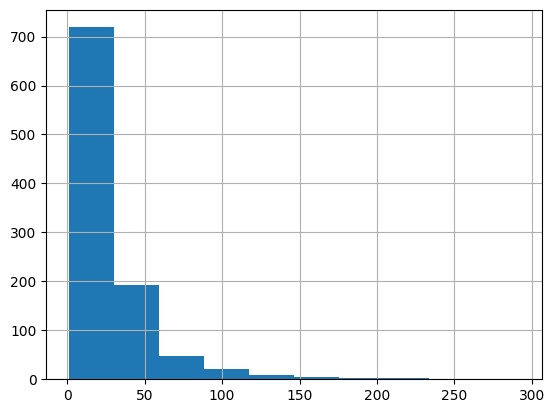

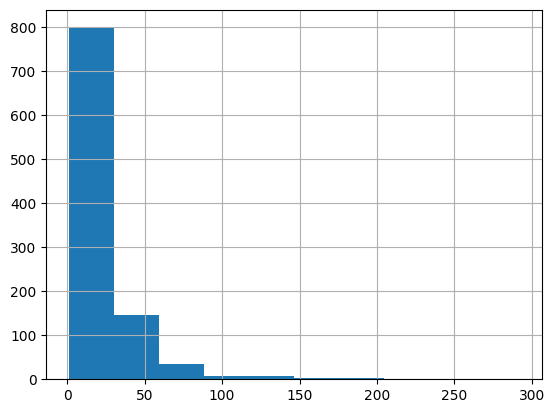

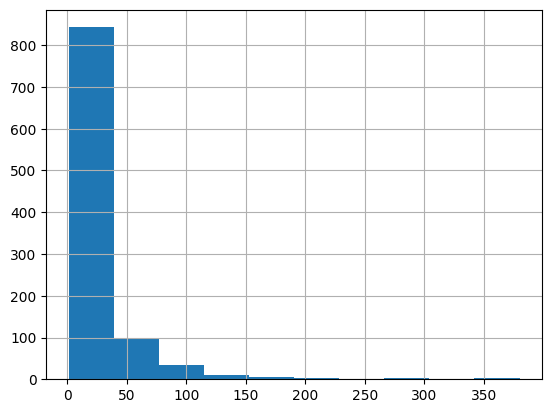

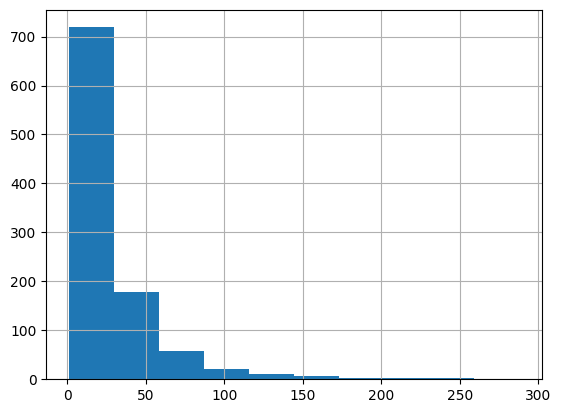

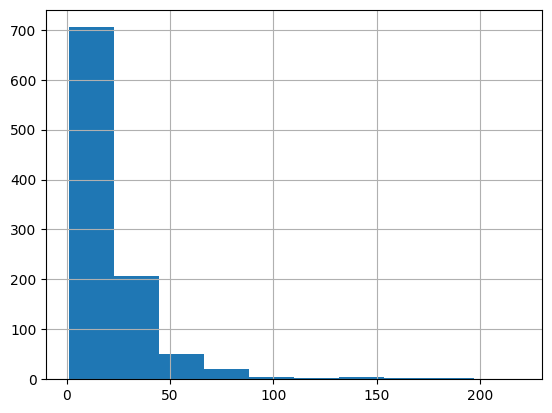

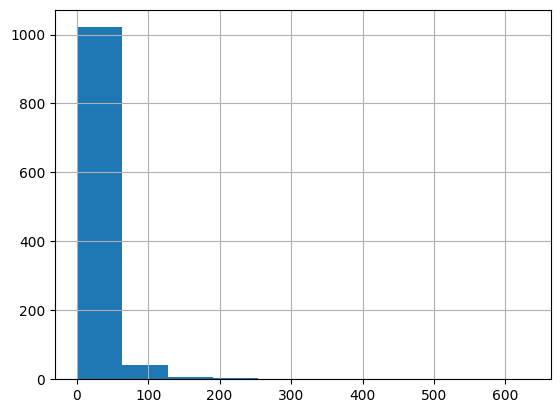

In [5]:
seq_len = [len(i.split()) for i in input_pre[0:1000]]
pd.Series( seq_len).hist( bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[1000:2000]]
pd.Series( seq_len).hist( bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[2000:3000]]
pd.Series( seq_len).hist( bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[3000:4000]]
pd.Series( seq_len).hist( bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[4000:5000]]
pd.Series( seq_len).hist( bins = 10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[5000:6100]]
pd.Series( seq_len).hist( bins = 10)
plt.show()


In [5]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3)

tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split = ' ')
tokenizer_data .fit_on_texts(input_pre)

tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding = 'post', maxlen = 820)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))
print("input data.shape:", vec_data.shape)
data_vocab_size = len (tokenizer_data.word_index)+1
print("data_vocab_size: ", data_vocab_size)

x_train, x_test, y_train, y_test = train_test_split( vec_data, label_tf, test_size = 0.2, random_state = 42)
print("training sample: ", len(x_train))
print("test sample: ", len(x_test))


input data.shape: (10036, 820)
data_vocab_size:  6235
training sample:  8028
test sample:  2008


In [6]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 820
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape = (input_length,))
    feature = Embedding( input_dim = input_dim, output_dim = output_dim, input_length = input_length,
                        embeddings_initializer = "GlorotNormal")(input_layer)

    cnn_feature = Conv1D( filters = 32, kernel_size = 16, padding = 'same', activation = 'relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold )(cnn_feature)
    cnn_feature = Conv1D( filters = 32, kernel_size = 16, padding = 'same', activation = 'relu') (cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold )(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=16, dropout = dropout_threshold, return_sequences = True, 
                                         kernel_initializer = initializer), merge_mode = 'concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    bi_lstm_feature = Bidirectional(GRU(units=16, dropout = dropout_threshold, return_sequences = True, 
                                        kernel_initializer = initializer), merge_mode = 'concat')(bi_lstm_feature)

    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature ])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation = 'relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation = 'relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation = 'relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation = 'relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation = 'softmax')(classifier)

    model =  tf.keras.Model(inputs = input_layer, outputs = classifier)

    return model

model = generate_model()
adam = Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss ='categorical_crossentropy', metrics = ['accuracy'])
model.summary()


c:\Users\LG\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 820)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 820, 32)   │    199,520 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 820, 32)   │     16,416 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 410, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 410, 32)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 820, 32)   │      6,272 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 410, 32)   │     16,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 410, 32)   │          0 │ bidirectional[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 205, 32)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 410, 32)   │      4,800 │ max_pooling1d_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 205, 32)   │         64 │ max_pooling1d_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 205, 32)   │          0 │ bidirectional_1[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 205, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 205, 32)   │         64 │ max_pooling1d_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 205, 64)   │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ global_max_pooli… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │      5,850 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 261,073 (1019.82 KB)

 Trainable params: 261,073 (1019.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras', monitor = 'val_loss')
history = model.fit( x = x_train, y = y_train, epochs = 15, batch_size = 128, 
                    callbacks = [callback_model])


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4120 - loss: 1.0607
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.4925 - loss: 1.0055
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.4768 - loss: 0.9609
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5838 - loss: 0.8073
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6793 - loss: 0.6751
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7837 - loss: 0.5382
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8510 - loss: 0.4180
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8821 - loss: 0.3474
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9007 - loss: 0.3074
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9061 - loss: 0.2806
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9187 - loss: 0.2437
Epoch 12/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy:

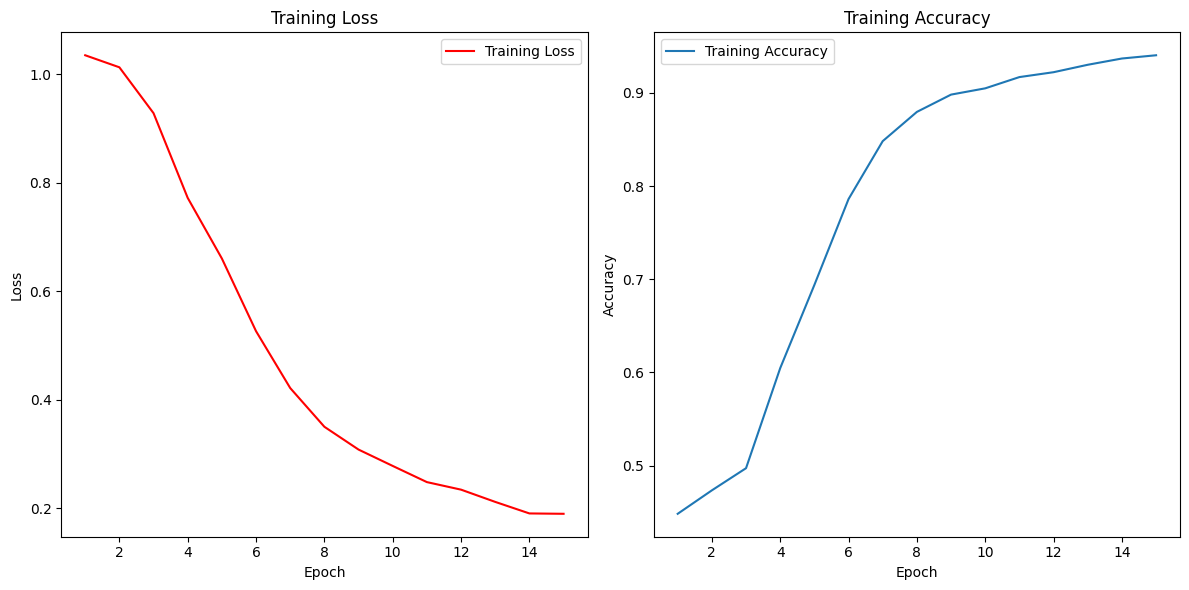

In [8]:
import matplotlib.pyplot as plt

# Lấy thông tin từ đối tượng history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
epochs = range(1, len(train_loss) + 1)

# Vẽ biểu đồ Loss và Accuracy trên cùng một biểu đồ
plt.figure(figsize=(12, 6))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color = 'red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7929 - loss: 0.6483
Test Loss: 0.614970326423645
Test Accuracy: 0.8082669377326965
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step


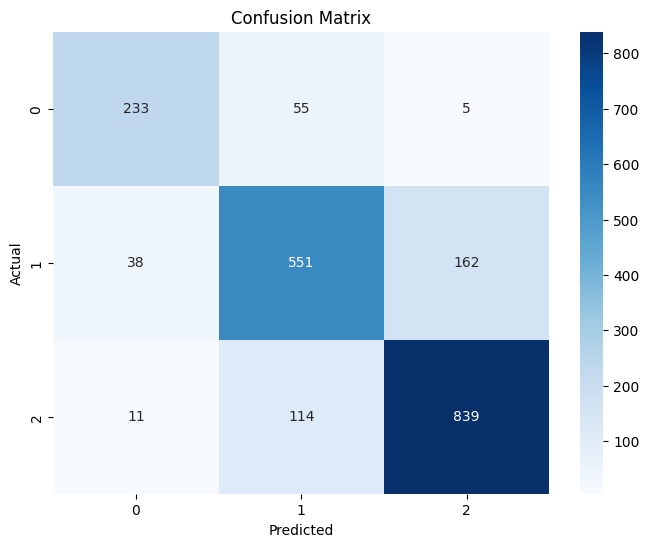

              precision    recall  f1-score   support

    Tiêu cực       0.83      0.80      0.81       293
   Trung lập       0.77      0.73      0.75       751
    Tích cực       0.83      0.87      0.85       964

    accuracy                           0.81      2008
   macro avg       0.81      0.80      0.80      2008
weighted avg       0.81      0.81      0.81      2008



In [10]:
# Load the best weights
model.load_weights('model_cnn_bilstm.keras')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict the test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print a classification report
report = classification_report(y_true, y_pred, target_names=label_dict.keys())
print(report)

